# Análise de Tweets de disastres naturais

In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [80]:
df = pd.read_csv("train.csv")
df.head(5)

,id,keyword,location,text,target
0,1118,blew%20up,"Brooklyn, NY",@YahooSchwab easy way to look good after the R...,0
1,1558,bomb,NaN,@dopeitsval ahh you're bomb baby ??,0
2,4830,evacuation,NaN,Run out evacuation hospital indexing remedial ...,1
3,3674,destroy,Trackside California,Wow Crackdown 3 uses multiple servers in multi...,0
4,5368,fire%20truck,NaN,wild night in the village of pugwash every fir...,1


<BarContainer object of 2 artists>

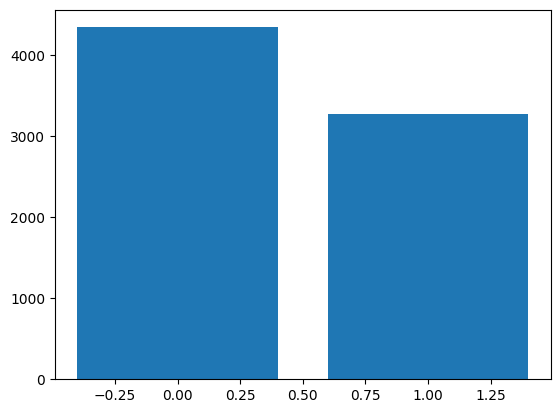

In [81]:
# Verificando desbalanceamento de classes
class_count = df.groupby("target").id.count()
plt.bar(height=class_count, x=class_count.keys())

In [82]:
# verificando entradas NaN nas colunas
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [83]:
df.describe(include="object")

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


# Pré-processamento

In [84]:
import nltk

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
sw_nltk = nltk.corpus.stopwords.words("english")
sw_nltk.append("amp")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [85]:
import sys
import re

from unicodedata import category
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from typing import Self
import contractions

codepoints = range(sys.maxunicode + 1)
punctuation = {c for i in codepoints if category(c := chr(i)).startswith("P")}
punctuation.add("...")
punctuation.add("'s")

class Preprocessor:
    def __init__(self, dataframe: pd.DataFrame):
        self._df = dataframe.copy()
    
    def to_lowercase(self, column: str) -> Self:
        self._df[column] = self._df[column].str.lower()
        return self
    
    def remove_html_artifacts(self, column:str) -> Self:
        self._df[column] = self._df[column].apply(lambda x: x.replace("%20", " "))
        return self
    
    def tokenize(self, column: str) -> Self:
        self._df[column] = self._df[column].apply(lambda x: word_tokenize(x))
        return self
    
    def expand_contractions(self, column: str) -> Self:
        #func = lambda x: [contractions.fix(w) for w in x]
        self._df[column] = self._df[column].apply(lambda x: contractions.fix(x))
        return self
    
    def remove_links(self, column: str) -> Self:
        # O regex busca tudo que começa com http: ou https:
        self._df[column] = self._df[column].apply(lambda x: re.sub(r'http\S+', '', x))
        return self
    
    def remove_punctuation(self, column: str) -> Self:
        func = lambda x: [w for w in x if not w in punctuation]
        self._df[column] = self._df[column].apply(func)
        return self
        
    def remove_stopwords(self, column: str) -> Self:
        func = lambda x: [w for w in x if w not in sw_nltk]
        self._df[column]  = self._df[column].apply(func)
        return self
    
    def remove_numbers(self, column: str) -> Self:
        func = lambda x: [w for w in x if not w.isdigit()]
        self._df[column]  = self._df[column].apply(func)
        return self
    
    def lemmatize(self, column: str) -> Self:
        lemmatizer = WordNetLemmatizer()
        func = lambda x: [lemmatizer.lemmatize(w) for w in x]
        self._df[column]  = self._df[column].apply(func)
        return self
    
    def get_df(self) -> pd.DataFrame:
        return self._df

In [86]:
df = df.drop("location", axis=1)
df = df.dropna()
df

,id,keyword,text,target
0,1118,blew%20up,@YahooSchwab easy way to look good after the R...,0
1,1558,bomb,@dopeitsval ahh you're bomb baby ??,0
2,4830,evacuation,Run out evacuation hospital indexing remedial ...,1
3,3674,destroy,Wow Crackdown 3 uses multiple servers in multi...,0
4,5368,fire%20truck,wild night in the village of pugwash every fir...,1
...,...,...,...,...
7608,9586,thunder,The thunder shook my house woke my sister and ...,1
7609,2271,cliff%20fall,Photographer Brian Ruebs endures 4500-feet cli...,0
7610,7833,quarantine,Reddit Will Now Quarantine Offensive Content h...,0
7611,2666,crush,samel_samel has a crush: http://t.co/tBsTk5VqU0,0


In [87]:
contractions.fix("i'm broken")

'i am broken'

In [88]:
preprocessor = Preprocessor(df)
col_nm = "text"

processed_df = preprocessor.to_lowercase(col_nm)\
            .remove_links(col_nm)\
            .expand_contractions(col_nm)\
            .tokenize(col_nm)\
            .remove_stopwords(col_nm)\
            .remove_numbers(col_nm)\
            .remove_punctuation(col_nm)\
            .lemmatize(col_nm)\
            .remove_html_artifacts("keyword")\
            .get_df()
            
processed_df

,id,keyword,text,target
0,1118,blew up,"[yahooschwab, easy, way, look, good, ray, rice...",0
1,1558,bomb,"[dopeitsval, ahh, bomb, baby]",0
2,4830,evacuation,"[run, evacuation, hospital, indexing, remedial...",1
3,3674,destroy,"[wow, crackdown, us, multiple, server, multipl...",0
4,5368,fire truck,"[wild, night, village, pugwash, every, fire, t...",1
...,...,...,...,...
7608,9586,thunder,"[thunder, shook, house, woke, sister, made, ca...",1
7609,2271,cliff fall,"[photographer, brian, ruebs, endures, 4500-fee...",0
7610,7833,quarantine,"[reddit, quarantine, offensive, content]",0
7611,2666,crush,"[samel_samel, crush]",0


# EDA

In [89]:
from collections import Counter

def count_common_words(series: pd.Series):
    c = Counter()
    
    for row in series:
        for token in set(row):
            c[token] += 1
    return c

In [90]:
negative = count_common_words(processed_df[processed_df.target == 0].text)
negative.most_common(10)

[('like', 241),
 ('get', 176),
 ('new', 163),
 ('would', 136),
 ('one', 129),
 ('body', 113),
 ('want', 104),
 ('going', 104),
 ('people', 101),
 ('time', 99)]

In [91]:
positive = count_common_words(processed_df[processed_df.target == 1].text)
positive.most_common(10)

[('fire', 233),
 ('news', 130),
 ('via', 120),
 ('people', 106),
 ('california', 104),
 ('disaster', 97),
 ('police', 95),
 ('suicide', 95),
 ('home', 94),
 ('train', 94)]

(-0.5, 799.5, 799.5, -0.5)

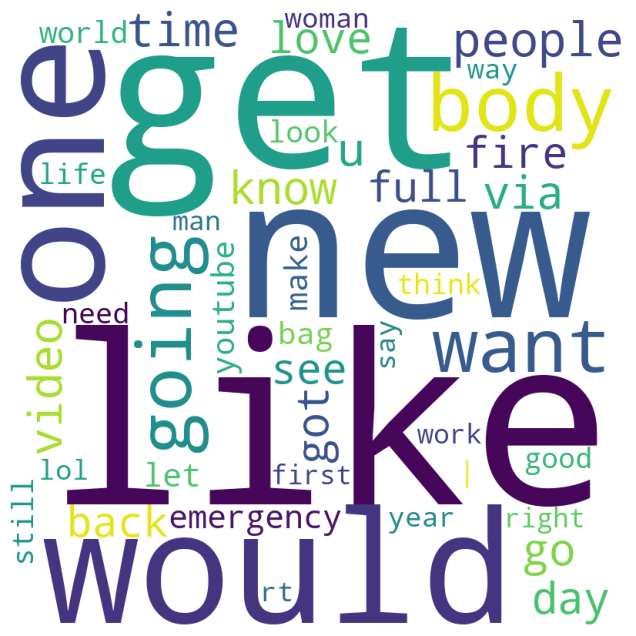

In [92]:
from wordcloud import WordCloud

# WordCloud para casos negativos
cloud = WordCloud(width=800, height=800, 
                  background_color="white",
                  max_words=45)
cloud.generate_from_frequencies(negative)

plt.figure(figsize= (8, 8))
plt.imshow(cloud)
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

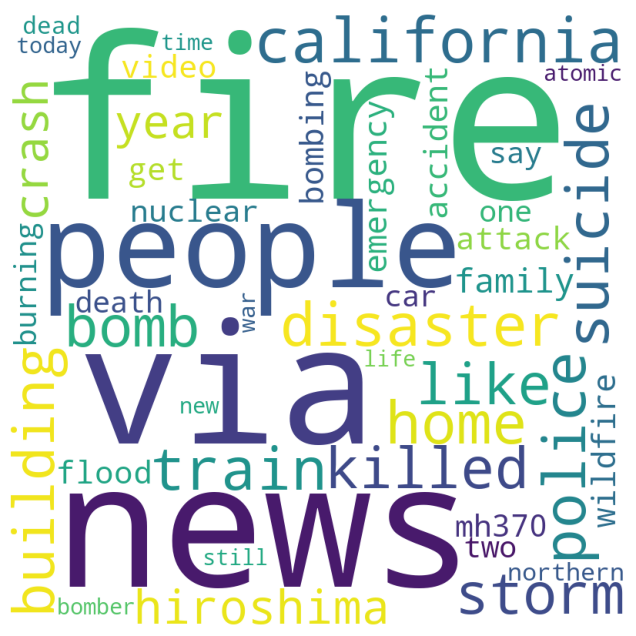

In [93]:
# WordCloud para casos positivos
cloud = WordCloud(width=800, height=800, 
                  background_color="white",
                  max_words=45)
cloud.generate_from_frequencies(positive)

plt.figure(figsize= (8, 8))
plt.imshow(cloud)
plt.axis("off")

(0.0, 1.0)

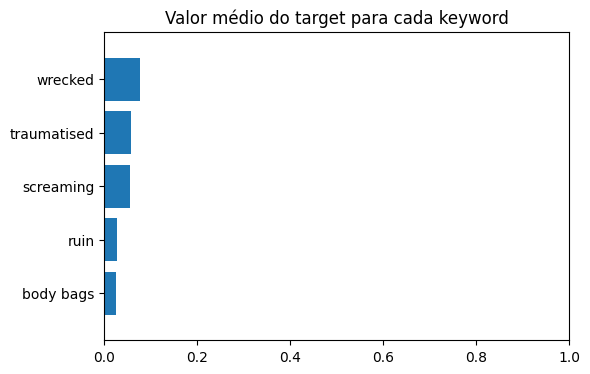

In [94]:
keyword_counts = processed_df.groupby("keyword")["target"].agg(["mean", "count"]).sort_values("count", ascending=False).head(100).sort_values("mean")
autism = keyword_counts.head(5)

y = [i for i in range(0, 5)]

plt.figure(figsize=(6, 4))
plt.title("Valor médio do target para cada keyword")
plt.yticks(y, autism.index.values.tolist())
plt.barh(y, autism["mean"])
plt.margins(x=0.1, y=0.1)

ax = plt.gca()
ax.set_xlim([0.0, 1.0])

# Modelagem

In [95]:
processed_df["text"] = processed_df["text"].apply(lambda x: " ".join(token for token in x))
processed_df["text"] = "KEYWORD: " + processed_df["keyword"] + "; " + processed_df["text"]
processed_df["text"]

0       KEYWORD: blew up; yahooschwab easy way look go...
1                 KEYWORD: bomb; dopeitsval ahh bomb baby
2       KEYWORD: evacuation; run evacuation hospital i...
3       KEYWORD: destroy; wow crackdown us multiple se...
4       KEYWORD: fire truck; wild night village pugwas...
                              ...                        
7608    KEYWORD: thunder; thunder shook house woke sis...
7609    KEYWORD: cliff fall; photographer brian ruebs ...
7610    KEYWORD: quarantine; reddit quarantine offensi...
7611                    KEYWORD: crush; samel_samel crush
7612    KEYWORD: drought; blog rain much needed drough...
Name: text, Length: 7552, dtype: object

In [96]:
processed_df["target"] = processed_df["target"].astype("float")

In [97]:
from datasets import Dataset

ds = Dataset.from_pandas(processed_df)

In [98]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_ds = ds.map(lambda x: tokenizer(x["text"]), batched=True)
tokenized_ds = tokenized_ds.rename_columns({"target":"labels"})

print(tokenized_ds["input_ids"][0])
print(tokenized_ds["text"][0])

c:\Users\User\Kaggle\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 7552/7552 [00:00<00:00, 29264.62 examples/s]


[1, 29908, 67111, 294, 12081, 322, 346, 32322, 79442, 10394, 639, 384, 468, 397, 16575, 4048, 40409, 12081, 2]
KEYWORD: blew up; yahooschwab easy way look good ray rice fiasco blew


In [99]:
dds = tokenized_ds.train_test_split(0.25)

In [100]:
from transformers import TrainingArguments, Trainer

bs = 128
epochs = 4
lr = 4e-5

args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [101]:
import evaluate

def corr(x,y): return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return metric.compute(predictions=logits, references=labels)

In [102]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokenizer, compute_metrics=compute_metrics)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
trainer.train()

 25%|██▌       | 45/180 [00:48<00:52,  2.56it/s]

{'eval_loss': 0.13591068983078003, 'eval_accuracy': 0.6853813559322034, 'eval_runtime': 3.37, 'eval_samples_per_second': 560.242, 'eval_steps_per_second': 2.374, 'epoch': 1.0}


 50%|█████     | 90/180 [01:21<00:46,  1.93it/s]

{'eval_loss': 0.13410283625125885, 'eval_accuracy': 0.7574152542372882, 'eval_runtime': 3.144, 'eval_samples_per_second': 600.512, 'eval_steps_per_second': 2.545, 'epoch': 2.0}


 75%|███████▌  | 135/180 [01:55<00:19,  2.35it/s]

{'eval_loss': 0.12719617784023285, 'eval_accuracy': 0.7356991525423728, 'eval_runtime': 3.2787, 'eval_samples_per_second': 575.846, 'eval_steps_per_second': 2.44, 'epoch': 3.0}


100%|██████████| 180/180 [02:36<00:00,  1.15it/s]

{'eval_loss': 0.1327146738767624, 'eval_accuracy': 0.7786016949152542, 'eval_runtime': 4.2053, 'eval_samples_per_second': 448.955, 'eval_steps_per_second': 1.902, 'epoch': 4.0}
{'train_runtime': 156.2653, 'train_samples_per_second': 144.984, 'train_steps_per_second': 1.152, 'train_loss': 0.14038659201727974, 'epoch': 4.0}


TrainOutput(global_step=180, training_loss=0.14038659201727974, metrics={'train_runtime': 156.2653, 'train_samples_per_second': 144.984, 'train_steps_per_second': 1.152, 'total_flos': 233718044406720.0, 'train_loss': 0.14038659201727974, 'epoch': 4.0})